<a href="https://colab.research.google.com/github/ebenajayi/C-Core_Design_Assistant/blob/main/ecse549.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load your data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
#X_train = data.iloc [0:1000,8]
#y_train = data.iloc [0:1000,0:8]
#
#scaler = StandardScaler()
#scaler.fit(y_train)
#y_train = scaler.transform(y_train)
#print('input i.e. inductance')
#print(X_train.head(-5))
#print('output')
#print(y_train)

In [ ]:
def induct(input):
  core_height = input[:, 0]
  back_core_width = input[:, 1]
  top_core_width = input[:, 2]
  pole_width = input[:, 3]
  core_width = input[:, 4]
  air_gap = input[:, 5]
  depth_core = input[:, 6]
  current = 1
  nturns = input[:, 7]
  perm_core = 1e3
  permeability_fs = 4e-7*np.pi
  perm = 1000

  mmf = current*nturns/2

  area_back_core = depth_core * back_core_width
  area_top_core = top_core_width * depth_core
  area_pole = depth_core * pole_width
  area_air_gap = depth_core * air_gap

  reluctance_back_core = (core_height - 2*top_core_width)/(2*perm_core*permeability_fs*area_back_core)
  reluctance_top_left_corner = top_core_width/(2*perm_core*permeability_fs*area_back_core) + back_core_width/(2*perm_core*permeability_fs*area_top_core)
  reluctance_top_core = (core_width - back_core_width - pole_width)/(perm_core*permeability_fs*area_top_core)
  reluctance_top_right_corner = (pole_width/(2*perm_core*permeability_fs*area_top_core)) + top_core_width/(2*perm_core*permeability_fs*area_pole)
  reluctance_pole = (core_height - air_gap - 2*top_core_width)/(2*perm_core*permeability_fs*area_pole)
  reluctance_air_gap = air_gap/(2*permeability_fs*area_air_gap)

  reluctance_total = reluctance_back_core + reluctance_top_left_corner + reluctance_top_core + reluctance_top_right_corner + reluctance_pole + reluctance_air_gap

  flux = mmf / reluctance_total

  inductance = nturns*flux/current
  return inductance

In [ ]:
# Train your model on train data
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense, Dropout, Lambda
from tensorflow.python.keras import Sequential, Model


model = Sequential()
model.add(Dense(1024, activation='linear', input_dim=1))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(8, name="last", activation='softplus'))
model.add(Lambda(induct))


model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

X_train = 1*np.random.rand(100000)+1e-6 # Generate random inductances

model.fit(X_train, X_train, epochs=30, batch_size= 512)

Epoch 1/30
196/196 [==============================] - 1s 4ms/step - loss: 81.1047 - mean_absolute_percentage_error: 81.1047
Epoch 2/30
196/196 [==============================] - 1s 4ms/step - loss: 16.5426 - mean_absolute_percentage_error: 16.5426
Epoch 3/30
196/196 [==============================] - 1s 4ms/step - loss: 15.2980 - mean_absolute_percentage_error: 15.2980
Epoch 4/30
196/196 [==============================] - 1s 4ms/step - loss: 12.8500 - mean_absolute_percentage_error: 12.8500
Epoch 5/30
196/196 [==============================] - 1s 4ms/step - loss: 9.8424 - mean_absolute_percentage_error: 9.8424
Epoch 6/30
196/196 [==============================] - 1s 4ms/step - loss: 7.1419 - mean_absolute_percentage_error: 7.1419
Epoch 7/30
196/196 [==============================] - 1s 4ms/step - loss: 3.8220 - mean_absolute_percentage_error: 3.8220
Epoch 8/30
196/196 [==============================] - 1s 4ms/step - loss: 4.7791 - mean_absolute_percentage_error: 4.7791
Epoch 9/30
196/1

Average error : 1.660501374789255%, Median error : 0.674551180220486%


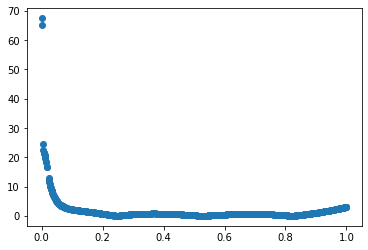

In [ ]:
test_induct = np.random.rand(1000)+1e-6 # Generate random inductances
#test_induct = X_train
inducts = model.predict(test_induct)


#circuits = scaler.inverse_transform(circuits)
#inducts = [induct(circuit) for circuit in circuits]
err = np.abs((test_induct - inducts) / test_induct) * 100
print(f"Average error : {np.average(err)}%, Median error : {np.median(err)}%")
plt.scatter(test_induct, err)

In [ ]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("last").output)

test_induct = 0.3 #@param {type:"number"}

circuit = intermediate_layer_model.predict([test_induct])[0]

print("Generated circuit :")
print(f"\t Core height : {circuit[0]:.2f} m")
print(f"\t Back core width : {circuit[1]:.2f} m")
print(f"\t Top core width : {circuit[2]:.2f} m")
print(f"\t Pole width : {circuit[3]:.2f} m")
print(f"\t Core width: {circuit[4]:.2f} m")
print(f"\t Air gap length : {circuit[5]:.2f} m")
print(f"\t Depth of the core : {circuit[6]:.2f} m")
print(f"\t Number of turns : {circuit[7]:.2f}")
print(f"\t Actual inductance of the circuit: {induct(circuit[np.newaxis,:])[0]:.4f} H")

Generated circuit :
	 Core height : 5.35 m
	 Back core width : 2.66 m
	 Top core width : 16.20 m
	 Pole width : 8.56 m
	 Core width: 1.08 m
	 Air gap length : 0.08 m
	 Depth of the core : 55.57 m
	 Number of turns : 65.16
	 Actual inductance of the circuit: 0.2983 H
